Chase Jamieson 

# Lichess Puzzle Analysis

I played Chess Competitively in Highschool, we're taught many different ways to study
openings, tactics and common heuristics to improve. But there's a common mismatch between
what you study and what people ACTUALLY play in the game. 

<img src="playing.jpg" width="600" />

I chose the dataset below because it can give insight into mistakes and weaknesses across various 
skill ratings from real games, not positions from a chess book. These insights could be used as heuristics to apply
in my own personal games

# The dataset

A set of puzzles generated from real user games on lichess.org with puzzle defined as: All player moves of the solution are "only moves". I.e. playing any other move would considerably worsen the player position. The Original dataset is nearly 5 million puzzles, too large for this project so I've reduced it into a smaller csv. 

[Database link](https://database.lichess.org/#puzzles)

<p float="left">
  <img src="intro1.png" width="400" />
  <img src="intro2.png" width="400" /> 
</p>

Do some imports, and display first few rows

In [36]:
import pandas as pd
import seaborn as sns
import chess
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

In [4]:
df = pd.read_csv('lichess_db_puzzle.csv')
df.head(2)

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags
0,v6b7b,r2qkbnr/p4ppp/np2p3/3p4/3P4/2P2N2/PP3PPP/RNBQ1...,f8d6 d1a4 d8d7 a4a6,1231,76,95,17717,advantage fork opening short,https://lichess.org/XDVeFnDP/black#16,Caro-Kann_Defense Caro-Kann_Defense_Exchange_V...
1,v6bBo,3r2k1/pp3ppp/8/n2r3n/6b1/P7/1P1NN1P1/1qQKRB1R ...,c1b1 d5d2 d1c1 a5b3,1157,74,96,6263,mate mateIn2 middlegame short,https://lichess.org/Vx1OCxSk#47,NaN


# Data Feature Explanation

- **PuzzleId**
- **FEN** : A Notation describing board state where each row is described by the piece and num of empty tiles in a row
- **Moves** : Moves for Puzzle solution
- **Rating** : Difficulty Approximation of Puzzle
- **RatingDeviation**
- **Popularity** : -100 to 100 upvote/downvote system from user reviews
- **NbPlays** : Number of plays
- **Themes** : Themes in Puzzle
- **GameUrl**
- **OpeningTags** : For Puzzles before 20 moves, which opening was used, Null for when No OpeningTags

# Cleaning

FEN and Move notation just gives coordinates, not what piece was actually moved. We'll Add two columns for better description
which describe the first piece and second piece moved for the puzzle (first being the blunder and second the start of the solution) where uppercase represents white pieces and lowercase are black.  

In [5]:
def extract_first_two_pieces(row):
    board = chess.Board(row['FEN'])
    # extract moves from moves column
    uci_moves = row['Moves'].split()
    pieces = []
    for uci in uci_moves[:2]:
        # process move and get piece symbol
        move = chess.Move.from_uci(uci)
        piece = board.piece_at(move.from_square)
        pieces.append(piece.symbol() if piece else None)
        board.push(move)
    return pd.Series(pieces, index=['Piece1', 'Piece2'])

df[['Piece1', 'Piece2']] = df.apply(extract_first_two_pieces, axis=1)
df.head(2)

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags,Piece1,Piece2
0,v6b7b,r2qkbnr/p4ppp/np2p3/3p4/3P4/2P2N2/PP3PPP/RNBQ1...,f8d6 d1a4 d8d7 a4a6,1231,76,95,17717,advantage fork opening short,https://lichess.org/XDVeFnDP/black#16,Caro-Kann_Defense Caro-Kann_Defense_Exchange_V...,b,Q
1,v6bBo,3r2k1/pp3ppp/8/n2r3n/6b1/P7/1P1NN1P1/1qQKRB1R ...,c1b1 d5d2 d1c1 a5b3,1157,74,96,6263,mate mateIn2 middlegame short,https://lichess.org/Vx1OCxSk#47,NaN,Q,r


# Example 

Looking at the first entry, its FEN board and Moves, we see the first and second piece moved,
how themes and opening tags are accurate. One theme is Fork, this is because the Queen is 
forking the King and unprotected Knight, therefore black will decisively lose material.

## FEN : r2qkbnr/p4ppp/np2p3/3p4/3P4/2P2N2/PP3PPP/RNBQ1RK1 b kq - 0 8
## Moves : f8d6 d1a4 d8d7 a4a6
## Themes : advantage, fork, opening, short
## Piece1 : bishop (lowercase), Piece2 : Queen (Uppercase)

<p float="left">
  <img src="example1.png" width="400" />
  <img src="example2.png" width="400" /> 
</p>



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381122 entries, 0 to 381121
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   PuzzleId         381122 non-null  object
 1   FEN              381122 non-null  object
 2   Moves            381122 non-null  object
 3   Rating           381122 non-null  int64 
 4   RatingDeviation  381122 non-null  int64 
 5   Popularity       381122 non-null  int64 
 6   NbPlays          381122 non-null  int64 
 7   Themes           381122 non-null  object
 8   GameUrl          381122 non-null  object
 9   OpeningTags      78476 non-null   object
 10  Piece1           381122 non-null  object
 11  Piece2           381122 non-null  object
dtypes: int64(4), object(8)
memory usage: 34.9+ MB


In [7]:
df.describe()

,Rating,RatingDeviation,Popularity,NbPlays
count,381122.000000,381122.000000,381122.000000,381122.000000
mean,1491.495684,87.531512,85.778680,1662.169515
std,548.964487,32.216579,14.720035,4457.240133
min,399.000000,61.000000,-74.000000,0.000000
25%,1058.000000,75.000000,83.000000,103.000000
50%,1446.000000,78.000000,90.000000,359.000000
75%,1901.000000,88.000000,94.000000,1264.000000
max,3201.000000,500.000000,100.000000,235473.000000


In [8]:
print('Number of Beginner Puzzles:',len(df[df['Rating'] <= 1500]))
print('Number of Intermediate Puzzles:',len(df[(df['Rating'] > 1500) & (df['Rating'] <= 2200)]))
print('Number of Advanced Puzzles',len(df[df['Rating'] > 2200]))

Number of Beginner Puzzles: 203225
Number of Intermediate Puzzles: 131131
Number of Advanced Puzzles 46766


## Explanation

As we can see, most of the data is centered into the begineer and intermediate bins, of the 381,112 Puzzles there are 78,476 which contain an opening tag.

# Question 1
## Are there Pieces used Disproportionately for making mistakes or for starting the correct solution? Does this Vary across different Ratings?

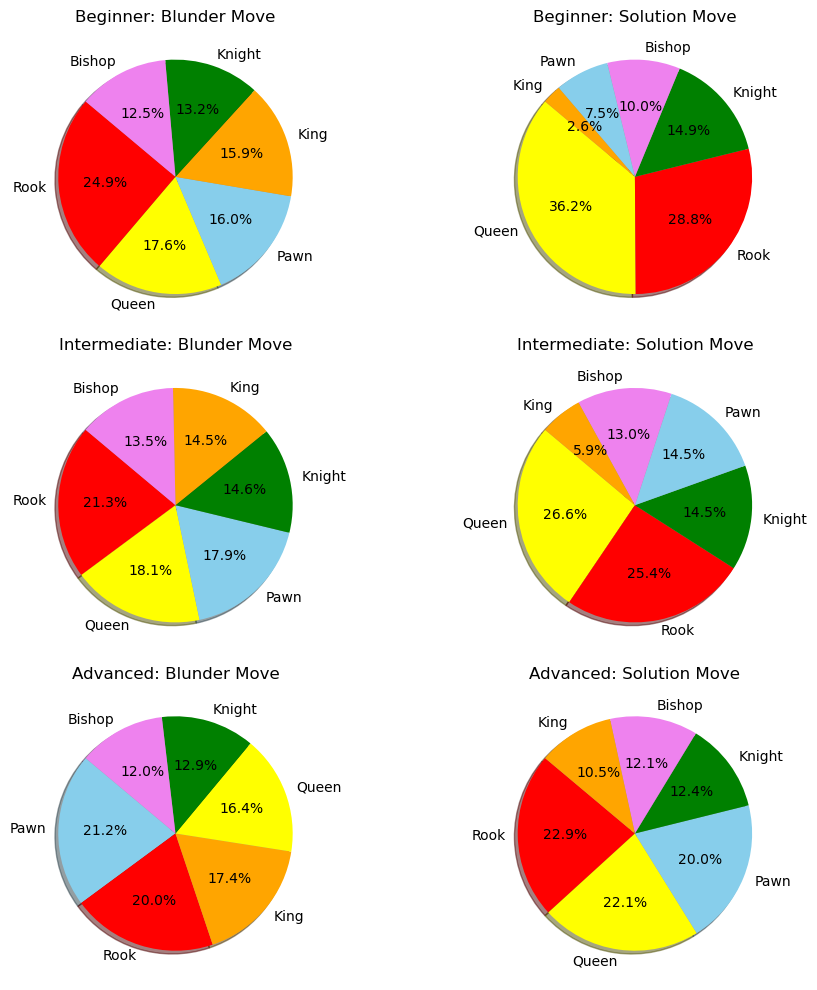

In [9]:
import matplotlib.pyplot as plt

# Split ratings into bins
df_beg = df[df['Rating'] <= 1500].copy()
df_int = df[(df['Rating'] > 1500) & (df['Rating'] <= 2200)].copy()
df_adv = df[df['Rating'] > 2200].copy()

# Map Piece letters to names
piece_names = {
    'R': 'Rook',
    'Q': 'Queen',
    'P': 'Pawn',
    'K': 'King',
    'N': 'Knight',
    'B': 'Bishop'
}

# Assign color for each piece
piece_colors = {
    'Rook': 'red',
    'Queen': 'yellow',
    'Pawn': 'skyblue',
    'King': 'orange',
    'Knight': 'green',
    'Bishop': 'violet'
}

# For each rating bin, map the piece letters to piece names
for df_group in [df_beg, df_int, df_adv]:
    for col in ['Piece1', 'Piece2']:
        df_group[col] = df_group[col].str.upper().map(piece_names)

# Function to compute percentages and colors
def compute_pct(df_col):
    pct = df_col.value_counts(normalize=True).rename_axis('Piece').reset_index(name='Percentage')
    pct['Percentage'] *= 100
    colors = [piece_colors[p] for p in pct['Piece']]
    return pct, colors

# Plot the 6 pie charts in 3,2 sublplot
datasets = [df_beg, df_beg, df_int, df_int, df_adv, df_adv]
columns = ['Piece1', 'Piece2'] * 3
titles = [
    'Beginner: Blunder Move', 'Beginner: Solution Move',
    'Intermediate: Blunder Move', 'Intermediate: Solution Move',
    'Advanced: Blunder Move', 'Advanced: Solution Move'
]

pie_data = [compute_pct(df[col]) for df, col in zip(datasets, columns)]

# Step 7: Plot 6 pie charts (2 per row)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, (data, colors), title in zip(axes, pie_data, titles):
    ax.pie(data['Percentage'], labels=data['Piece'], autopct='%1.1f%%',
           startangle=140, shadow=True, colors=colors)
    ax.set_title(title)

plt.tight_layout()
plt.show()


As the Rating increases the piece moved to begin the solution starts to balance out. At the lowest rating bin, nearly 70% of the solutions begin wiht just a rook or queen and a pawn is about 7.5%. However as we get to the advanced section, a pawn is now used 20% of the time and a Queen and Rook only account for ~45% of the solutions.

# Question 2
## What are the most common openings for generating puzzles?

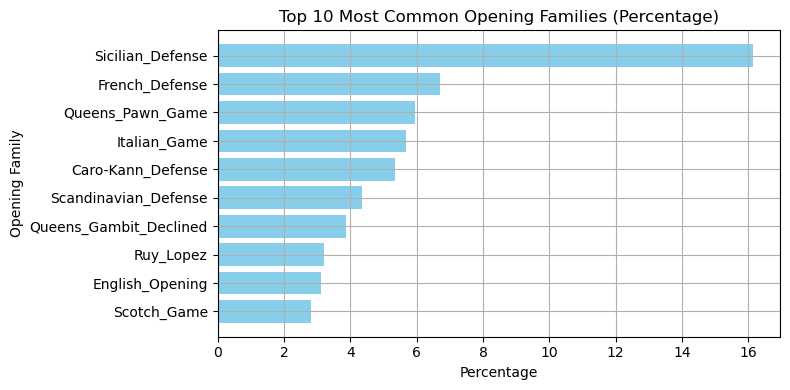

In [11]:
# Drop Null rows where no opening is listed
opening_series = df['OpeningTags'].dropna().copy()

# Get the first opening tag from each row
first_openings = opening_series.str.split().str[0]

# Count frequency of each first-opening
opening_counts = first_openings.value_counts(normalize=True).reset_index()
opening_counts.columns = ['OpeningVariation', 'Percentage']
opening_counts['Percentage'] *= 100

# Plot top 10 by percentage
top_openings = opening_counts.head(10)

plt.figure(figsize=(8, 4))
plt.barh(top_openings['OpeningVariation'][::-1], top_openings['Percentage'][::-1], color='skyblue')
plt.title(f"Top 10 Most Common Opening Families (Percentage)")
plt.xlabel("Percentage")
plt.ylabel("Opening Family")
plt.tight_layout()
plt.grid()
plt.show()


The by far most prevalent opening is the Sicilian Defense, and through a reference to lichess's database the Sicilian only account for about 10% of Chess games where'as here its 16% of the puzzles. It is therefore a disproportionately tactical opening.

# Question 3
## What are the preffered Variations of the Sicillian defense across various ratings?

In [12]:
# Take a cut from df using the rating bins
bins = [0, 1500, 2200, float('inf')]
labels = ['Beginner', 'Intermediate', 'Advanced']
df['RatingBin'] = pd.cut(df['Rating'], bins=bins, labels=labels)

# Filter for Sicilian Defense puzzles
sicilian_df = df[df['OpeningTags'].fillna('').str.contains('Sicilian_Defense')].copy()
sicilian_df['OpeningTags'] = sicilian_df['OpeningTags'].str.split()

# Explode tags into separate rows
# then remove the Parent opening
sicilian_exploded = sicilian_df.explode('OpeningTags')
sicilian_exploded = sicilian_exploded[sicilian_exploded['OpeningTags'] != 'Sicilian_Defense']

# Count variations within each rating bin
bin_low = sicilian_exploded[sicilian_exploded['RatingBin'] == 'Beginner']['OpeningTags'].value_counts().reset_index()
bin_mid = sicilian_exploded[sicilian_exploded['RatingBin'] == 'Intermediate']['OpeningTags'].value_counts().reset_index()
bin_high = sicilian_exploded[sicilian_exploded['RatingBin'] == 'Advanced']['OpeningTags'].value_counts().reset_index()

# Rename columns
bin_low.columns = ['OpeningVariation', 'Count']
bin_mid.columns = ['OpeningVariation', 'Count']
bin_high.columns = ['OpeningVariation', 'Count']

# find sum to calculate percentages
total_low = bin_low['Count'].sum()
total_mid = bin_mid['Count'].sum()
total_high = bin_high['Count'].sum()

bin_low['Percentage'] = (bin_low['Count'] / total_low) * 100
bin_mid['Percentage'] = (bin_mid['Count'] / total_mid) * 100
bin_high['Percentage'] = (bin_high['Count'] / total_high) * 100

print('-'*25,'LOW','-'*25)
print(bin_low.head(5))
print('-'*25,'MID','-'*25)
print(bin_mid.head(5))
print('-'*25,'HIGH','-'*25)
print(bin_high.head(5))


------------------------- LOW -------------------------
                     OpeningVariation  Count  Percentage
0     Sicilian_Defense_Bowdler_Attack    530    7.549858
1       Sicilian_Defense_Old_Sicilian    490    6.980057
2             Sicilian_Defense_Closed    471    6.709402
3   Sicilian_Defense_Alapin_Variation    460    6.552707
4  Sicilian_Defense_Najdorf_Variation    348    4.957265
------------------------- MID -------------------------
                     OpeningVariation  Count  Percentage
0       Sicilian_Defense_Old_Sicilian    326    6.967301
1             Sicilian_Defense_Closed    317    6.774952
2  Sicilian_Defense_Najdorf_Variation    302    6.454371
3     Sicilian_Defense_Bowdler_Attack    295    6.304766
4   Sicilian_Defense_Alapin_Variation    274    5.855952
------------------------- HIGH -------------------------
                      OpeningVariation  Count  Percentage
0              Sicilian_Defense_Closed     71    6.179286
1   Sicilian_Defense_Najdorf_Va

The preferred opening variations change as the ratings change. For example, the Bowdler Attack is the most poular in the lowest bin and it isn't even in the top 5 among the highest bin. By contrast, the Najdorf gets more popular as the rating increases. Lastily, the Old Sicilian is the most consistent variation across each rating bin.

# Question 4
## What are the most popular and least popular puzzle themes?

In [14]:
# Drop rows with missing Themes or Popularity
df_themes = df.copy()

# Split the Themes column into multiple tags
df_themes['Themes'] = df_themes['Themes'].str.split()

# Explode the tags to individual rows
df_exploded = df_themes.explode('Themes')

# Group by theme and calculate average popularity
theme_popularity = (
    df_exploded
    .groupby('Themes')['Popularity']
    .mean()
    .reset_index()
    .sort_values(by='Popularity', ascending=False)
)

# Get top and bottom 5 themes by average popularity
top_5 = theme_popularity.head(5)
bot_5 = theme_popularity.tail(5)

print(top_5)
print('-'*25)
print(bot_5)


      Themes  Popularity
21  equality   92.963147
38   mateIn4   89.430171
39   mateIn5   88.955381
25  hookMate   88.193701
37   mateIn3   87.738028
-------------------------
              Themes  Popularity
24      hangingPiece   84.401457
47  queenRookEndgame   84.362677
10          castling   84.261364
54     smotheredMate   83.911807
6       backRankMate   82.299081


Over popularity scores are very close, however 'equality' themes which are puzzles where you're losing and find a combination to equalize the game are clearly the top by several percentage points. The most unpopular is clearly 'backRankMate' which is a very, perhaps the most common beginner mistake.

# Question 5
## Are certain themes (e.g., 'crushing', 'endgame') more prevalent in high-rated puzzles?

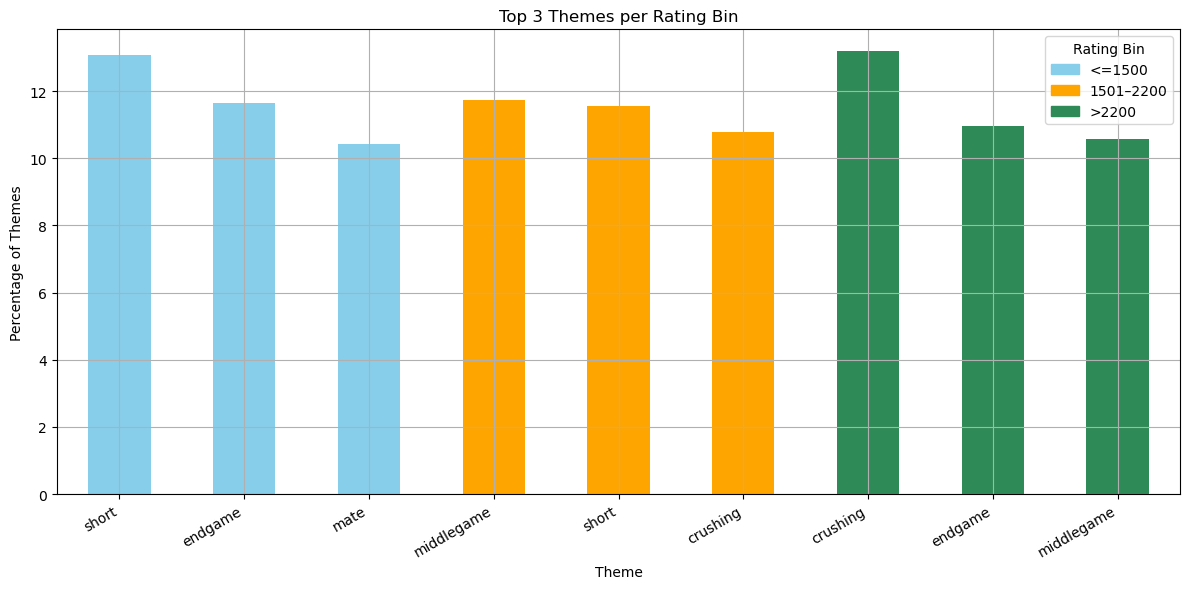

In [26]:
# Split into rating bins
df_beg = df[df['Rating'] <= 1500].copy()
df_int = df[(df['Rating'] > 1500) & (df['Rating'] <= 2200)].copy()
df_adv = df[df['Rating'] > 2200].copy()

# Function to get top 3 theme percentages
def top_themes_percent(df_subset, label):
    df_subset = df_subset.dropna(subset=['Themes']).copy()
    df_subset['Themes'] = df_subset['Themes'].str.split()
    exploded = df_subset.explode('Themes') # explode the themes
    total = len(exploded) # remember  total
    top3 = exploded['Themes'].value_counts().head(3) # extract top 3
    top3_pct = (top3 / total * 100).rename_axis('Theme').reset_index(name='Percentage') # calc percentage
    top3_pct['RatingBin'] = label
    return top3_pct

# Get top 3 theme percentages per bin
top_beg = top_themes_percent(df_beg, '<=1500')
top_int = top_themes_percent(df_int, '1501–2200')
top_adv = top_themes_percent(df_adv, '>2200')

# Combine into one frame and add composite label
stacked = pd.concat([top_beg, top_int, top_adv], ignore_index=True)
stacked['Label'] = stacked['Theme']

# Prepare data for plotting
plot_data = stacked[['Label', 'RatingBin', 'Percentage']].set_index('Label')
color_map = {'<=1500': 'skyblue', '1501–2200': 'orange', '>2200': 'seagreen'}
bar_colors = [color_map[r] for r in plot_data['RatingBin']]

# Plot
plot_data['Percentage'].plot(
    kind='bar',
    color=bar_colors,
    figsize=(12, 6)
)

plt.title("Top 3 Themes per Rating Bin")
plt.ylabel("Percentage of Themes")
plt.xlabel("Theme")
plt.xticks(rotation=30, ha='right')
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=color_map[k]) for k in color_map],
           labels=list(color_map.keys()), title='Rating Bin')
plt.tight_layout()
plt.grid()
plt.show()


Endgame theme is popular at both low ratinng and high ratings, there is no common top 3 theme across the three rating bins. At the two lower bins however, short puzzles are among the most popular however not at the highest bin.

# Question 6

## What is the average length of puzzles per rating tier?



In [29]:
# define aforementioned rating bins
bins = [0, 1500, 2200, float('inf')]
labels = ['<=1500', '1501–2200', '>2200']
df['RatingBin'] = pd.cut(df['Rating'], bins=bins, labels=labels)

# Add column to Count the number of moves in each puzzle
# moves are separated by whitespace
df['NumMoves'] = df['Moves'].str.split().apply(len)

# Step 3: Calculate average number of moves per rating bin
avg_moves_by_bin = (
    df.groupby('RatingBin', observed=True)['NumMoves']
    .mean()
    .reset_index(name='AverageMoves')
)

avg_moves_by_bin

,RatingBin,AverageMoves
0,<=1500,3.927027
1,1501–2200,5.151780
2,>2200,6.416285


The average puzzle length starts at 4 in the lowest bin and then increases by one in each bin, ending 6.4 average for the highest bin.

# Question 7

## Are there consistently unpopular themes across the rating distribution?

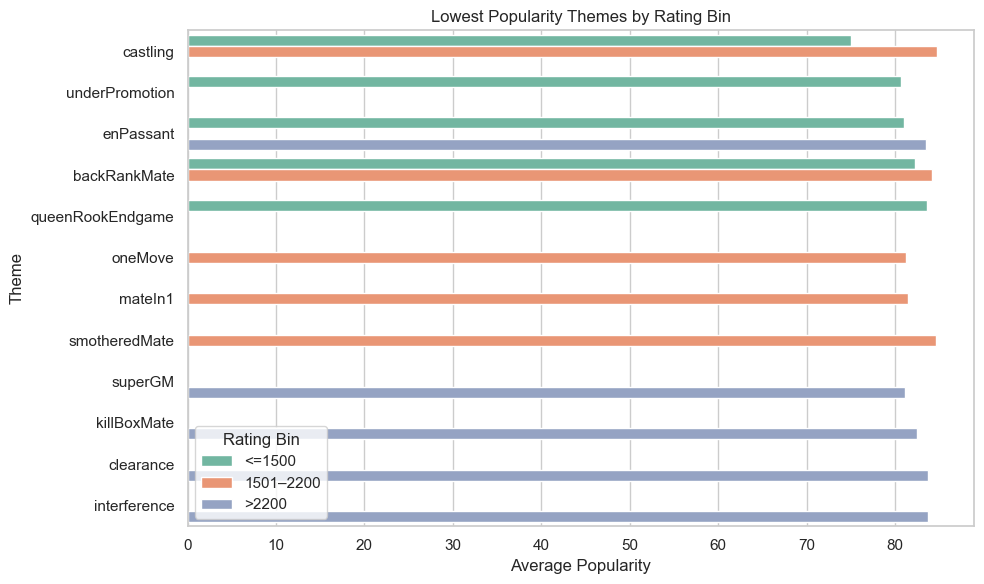

In [34]:
# Assuming 'df' is your loaded dataset
df_themes = df.dropna(subset=['Themes']).copy()
df_themes['Themes'] = df_themes['Themes'].str.split()

# Expand themes into separate rows
df_exploded = df_themes.explode('Themes')

# Compute average popularity by theme and rating bin
theme_popularity = (
    df_exploded
    .groupby(['RatingBin', 'Themes'], observed=True)['Popularity']
    .mean()
    .reset_index(name='AvgPopularity')
)

# Get bottom 5 least popular themes per bin
lowest_by_bin = (
    theme_popularity
    .sort_values(['RatingBin', 'AvgPopularity'])
    .groupby('RatingBin', observed=True)
    .head(5)
)

# using seaborn now for plot
sns.set(style="whitegrid")

# Create figure and plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=lowest_by_bin,
    x='AvgPopularity',
    y='Themes',
    hue='RatingBin',
    dodge=True,
    palette='Set2'
)

plt.title("Lowest Popularity Themes by Rating Bin")
plt.xlabel("Average Popularity")
plt.ylabel("Theme")
plt.legend(title='Rating Bin', loc='lower left')
plt.tight_layout()
plt.show()

The Average popularity of the lowest themes has very little variation. However in the Lowest bin 'castling' is clearly an unpopular theme. For Intermediate the lowest themes are OneMove and mateIn1, at the highest level its 'superGM' which are puzzles generated from games of the best Grandmasters (I suspect they're very tough puzzles).

# Question 8

## How many unique themes do puzzles typically have, and how does that vary by rating?


In [42]:
# Count unique themes
df_theme_counts = df.dropna(subset=['Themes']).copy()
df_theme_counts['ThemeCount'] = df_theme_counts['Themes'].str.split().apply(lambda x: len(set(x)))

# Compute average by bin
avg_theme_counts = (
    df_theme_counts
    .groupby('RatingBin', observed=True)['ThemeCount']
    .mean()
    .reset_index(name='AverageNumThemes')
)
avg_theme_counts

,RatingBin,AverageNumThemes
0,<=1500,4.477018
1,1501–2200,4.368181
2,>2200,4.526087


There are only slightly more themes on average in the higher level puzzle themes, however it seems to be fairly consistent across all rating categories.

# Question 9

## What are the most common combinations of 2 or 3 themes in high-rated puzzles?


In [38]:

high_rated_df = df[df['Rating'] > 2200].dropna(subset=['Themes']).copy()

# sort sets to count 
high_rated_df['Themes'] = high_rated_df['Themes'].str.split().apply(lambda x: sorted(set(x)))

# count size 3 combinations
combo_3_counter = Counter()
for theme_list in high_rated_df['Themes']:
    if len(theme_list) >= 3:
        combo_3_counter.update(combinations(theme_list, 3))

# Step 4: Get the top 15 most common 3-theme combinations
most_common_3_combos = combo_3_counter.most_common(10)
combo_3_df = pd.DataFrame(most_common_3_combos, columns=['ThemeCombination', 'Count'])

combo_3_df

,ThemeCombination,Count
0,"(crushing, endgame, long)",7002
1,"(crushing, endgame, veryLong)",6196
2,"(crushing, defensiveMove, endgame)",5295
3,"(advantage, long, middlegame)",5132
4,"(crushing, endgame, short)",4492
5,"(crushing, endgame, quietMove)",4336
6,"(crushing, long, middlegame)",4105
7,"(advantage, middlegame, short)",3648
8,"(crushing, endgame, pawnEndgame)",3551
9,"(crushing, endgame, master)",3058


The most common combinations tend to be very long or long endgame puzzles. 

# Question 10

## Which puzzles have high rating deviation, and what do they have in common?

In [40]:
# take the top 2%
threshold = df['RatingDeviation'].quantile(0.98)

# Step 2: Filter for high deviation puzzles
high_dev_df = df[df['RatingDeviation'] >= threshold].copy()

# Step 3: Drop missing themes and split into lists
high_dev_df = high_dev_df.dropna(subset=['Themes'])
high_dev_df['Themes'] = high_dev_df['Themes'].str.split()

# Step 4: Explode themes into individual rows and count top 10
theme_counts = (
    high_dev_df.explode('Themes')['Themes']
    .value_counts()
    .head(5)
    .reset_index()
)
theme_counts.columns = ['Theme', 'Count']

# Display result
print(theme_counts)

        Theme  Count
0     endgame   3832
1       short   3708
2  middlegame   3463
3        mate   2935
4    crushing   2388


Short Puzzles and puzzles in the endgame tend to have the most rating variation, meaning there is a high degree of uncertainity in the difficulty of the puzzle. 

# Conclusion

1. At the lower levels, Queens and Rook moves are the most important by far, as rating increases Pawn moves become just as important as Queens and Rooks.
2. The by far best opening to find puzzles is the Sicillian defense.
3. Some variations perform better at lower ratings and some perform better at higher ratings:
4. castling and one move puzzles are very unpopular.
5. Puzzles that equalize the game rather than win the game are much more popular. (basically a comeback puzzle)
6. As Rating increases Puzzles get longer but retain the same number of themes.

# Future Work

1. Analyze with the FULL dataset to see if the results change.
2. Account for the frequency of openings by looking at the full lichess database, and for individual playing abilities.